# Hands on: 3DMASC and Python
## Summer School Clouds2023, M. Letard

This notebook introduces the steps necessary to classify a 3D point cloud as introduced in the 3DMASC paper.

The following tasks are introduced:

1. Feature computation
2. Classification in Python (various algorithms possible)
3. Classification confidence analysis
4. Feature selection
5. Interpretability with SHAP

### Computing 3DMASC features in command line
Open the terminal in your cloudcompare.exe directory.
Type the following code in the terminal:

.\CloudCompare -c_export_fmt SBF -ext sbf -auto_save OFF -o PC1_path -o PC2_path -o PCX_path -o CTX_path -3dmasc_classify -only_features features_file_path "PCX=3 PC1=1 PC2=2 CTX=4" -save_clouds

Your resulting files will be saved in SBF format.

### Reading 3DMASC features in Python
You will need to clone the lidar_platform github repository (https://github.com/p-leroy/lidar_platform.git) and add it to your path variable using the following line:

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(r'../'))

In [2]:
from lidar_platform.classification import cc_3dmasc
from lidar_platform.classification import feature_selection
from lidar_platform.tools import *
import cv2
import sklearn

ModuleNotFoundError: No module named 'numpy'

First, define the path to the sbf files containing the features, and to the text file containing the 3DMASC parameters.

In [3]:
train_data_path = r'your_path'
val_data_path = r'your_path'
features_file = r'your_path'

Then, load the data using the sbf file reading function.

In [4]:
tra_ds = cc_3dmasc.load_sbf_features(train_data_path, features_file, labels=True)
val_ds = cc_3dmasc.load_sbf_features(val_data_path, features_file, labels=True)

### Performing classification using OpenCV's Random Trees

In [5]:
opencv_rtrees = cc_3dmasc.train(tra_ds, model=1)
labels_pred, conf, feat_imptce, oa, fs = cc_3dmasc.test(val_ds, opencv_rtrees, model=1)
print("OpenCV RF overall accuracy : "+ str(round(oa*100,2))+" %")

OpenCV RF : 85.22 %


### Using the classifier obtained with Python in CloudCompare and vice-versa

1- Save a classifier trained with Python to reuse it in the CC plugin

In [ ]:
opencv_rtrees.save(r'path\python_classifier.yaml') #this yaml file can then be opened in the CC plugin

2- Open a classifier trained with the CC plugin in Python and test it

In [8]:
cc_rtrees = cv2.ml.RTrees_load(r'path\plugin_classifier.yaml') #in this example, the yaml file was obtained with the CC plugin
labels_pred, conf, feat_imptce, oa, fs = cc_3dmasc.test(val_ds, cc_rtrees, model=1)
print("CC plugin - OpenCV RF overall accuracy: "+ str(round(oa*100,2))+" %")

OpenCV RF : 85.22 %


### Analysing prediction confidence

With Random Forest, we have access to a *prediction confidence* information, which we can analyse.

#### Analysing prediction errors' confidence

This informs us on how well the classifier is trained (in an ideal world, we would like the wrong predictions to have a low prediction confidence).

In [6]:
cc_3dmasc.classif_errors_confidence(labels_pred, val_ds['labels'], conf)

{'Mean_confidence': 0.9025213333333293,
 'Median_confidence': 0.98,
 'Min_confidence': 0.2733333333333333,
 'Max_confidence': 1.0,
 'Std_confidence': 0.1501067419849387}

#### Analysing prediction confidence thresholding impact on OA

We can choose to filter out the predictions with a low confidence value to see if the accuracy improves (which would mean that we filter out classification errors).

In [7]:
cc_3dmasc.confidence_filtering_report(labels_pred, val_ds['labels'], conf)

({0.5: 0.8657148768880613,
  0.6: 0.8757013379369875,
  0.7: 0.8833201043202177,
  0.8: 0.8902246508803886,
  0.9: 0.8947806774014436,
  0.95: 0.8939986953685584},
 {0.5: 0.9666,
  0.6: 0.9268,
  0.7: 0.8819,
  0.8: 0.8235,
  0.9: 0.7204,
  0.95: 0.6132})

### Performing classification using other algorithms from sklearn

In some cases, it can be interesting to use other approaches, or to use the sklearn implementation of RF for compatibility with further tools. It can be done easily, as illustrated in the following cells.

**1- sklearn implementation of Random Forest**


In [9]:
import sklearn
from sklearn import discriminant_analysis
classifier=cc_3dmasc.train(tra_ds, model=0)
classifier.fit(cc_3dmasc.feature_clean(tra_ds['features']),tra_ds['labels'])
pred_rf = classifier.predict(cc_3dmasc.feature_clean(val_ds['features']))
oa_rf = sklearn.metrics.accuracy_score(val_ds['labels'], pred_rf)
print("Sklearn RF overall accuracy : "+ str(round(oa_rf*100,2))+" %")

Sklearn RF : 84.77 %


**2 - AdaBoost + Random Forest**

In [10]:
adacl = sklearn.ensemble.AdaBoostClassifier(classifier)
adacl.fit(cc_3dmasc.feature_clean(tra_ds['features']), tra_ds['labels'])
pred = adacl.predict(cc_3dmasc.feature_clean(val_ds['features']))
oa = sklearn.metrics.accuracy_score(val_ds['labels'], pred)
print("Overall accuracy with AdaBoost : "+ str(round(oa*100,2))+" %")

With AdaBoost : 84.87 %


**3 - Linear Discriminant Analysis**

In [11]:
clf = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
clf.fit(cc_3dmasc.feature_clean(tra_ds['features']), tra_ds['labels'])
predlda = clf.predict(cc_3dmasc.feature_clean(val_ds['features']))
oalda = sklearn.metrics.accuracy_score(val_ds['labels'], predlda)
print("LDA overall accuracy: "+ str(round(oalda*100,2))+" %")

LDA : 71.8 %


### Selecting features automatically

To have a smaller predictor set or eliminate inter-feature correlation, it might be useful to perform automatic feature selection. The following cells introduce different ways of selecting features and scales.

**1 - selecting a chosen number of scales and features (here n_features = 5 and n_scales = 5).**

In this example, the features are evaluated at a computation scale of 6 m, and the correlation coefficient threshold used is 0.85. 

*Note: the algorithm will select* ***up to*** *n_features and n_scales uncorrelated features and scales. If there are less than n_features or n_scales respecting the criteria, less will be selected.*
*To select the biggest set of uncorrelated predictors possible, set n_features and n_scales to high values (e.g. the total number of features or scales in your parameter file).*


In [ ]:
select = feature_selection.get_n_optimal_sc_ft(tra_ds, val_ds, 5, 5, 6.0, 0.85)
print("Overall accuracy obtained with selected subset: ",select['OA'])

*The values printed correspond to the optimal scales identified, and to the Overall Accuracy obtained when using the subset of features to perform classification.*

**2 - optimizing the set of predictors: iterative pruning based on the embedded random forest feature importance and monitoring of the OOB score** (this is the iterative feature selection process used in the 3DMASC paper).

First, the biggest set of uncorrelated features and scales is selected (using the same code as the *get_n_optimal_sc_ft* function).
Then, the set is pruned iteratively: at each iteration, the least "important" feature is discarded and the RF model is trained again. To determine the optimized set (i.e. when to stop pruning), the variation of the OOB score is monitored (if the OOB score drops of more than a user-defined value, the pruning stops).

In the cell below, *rf_ft_selection* does the iterative pruning (until only 1 feature is left). Then, *get_best_rf_select_iter* identifies the iteration at which the number of predictors left is the smallest while maximising the OOB score.

In [13]:
select_rf = feature_selection.rf_ft_selection(tra_ds, val_ds, 5, 5, 6.0, threshold=0.85, step=1)
best_it = feature_selection.get_best_rf_select_iter(select_rf, tra_ds, val_ds, 2, 0.01)

['EchoRat_PC1_MEAN' 'EchoRat_PC2_MEAN' 'Number Of Returns_PC2_MEAN'
 'Intensity_PC2_MODE' 'Intensity_PC1_MEDIAN_DIVIDE_Intensity_PC2_MEDIAN'
 'SPHER_PC1' 'DZ_CTX_10@kNN=10' 'DZ_CTX_10@kNN=1']
[0, 2, 6, 7, 5]
2.0 Ground 0.0395
5.0 High_veg. 0.5645
6.0 Building 0.6735
9.0 Water 0.9985
16.0 Bathymetry 0.4345


*The output cell shows the list of selected features, the list of selected scales, and the producer's accuracy per label/class name.*

### Explainability with the SHAP method

Shapley values can be used to approximate the contribution of each feature to the decisions.

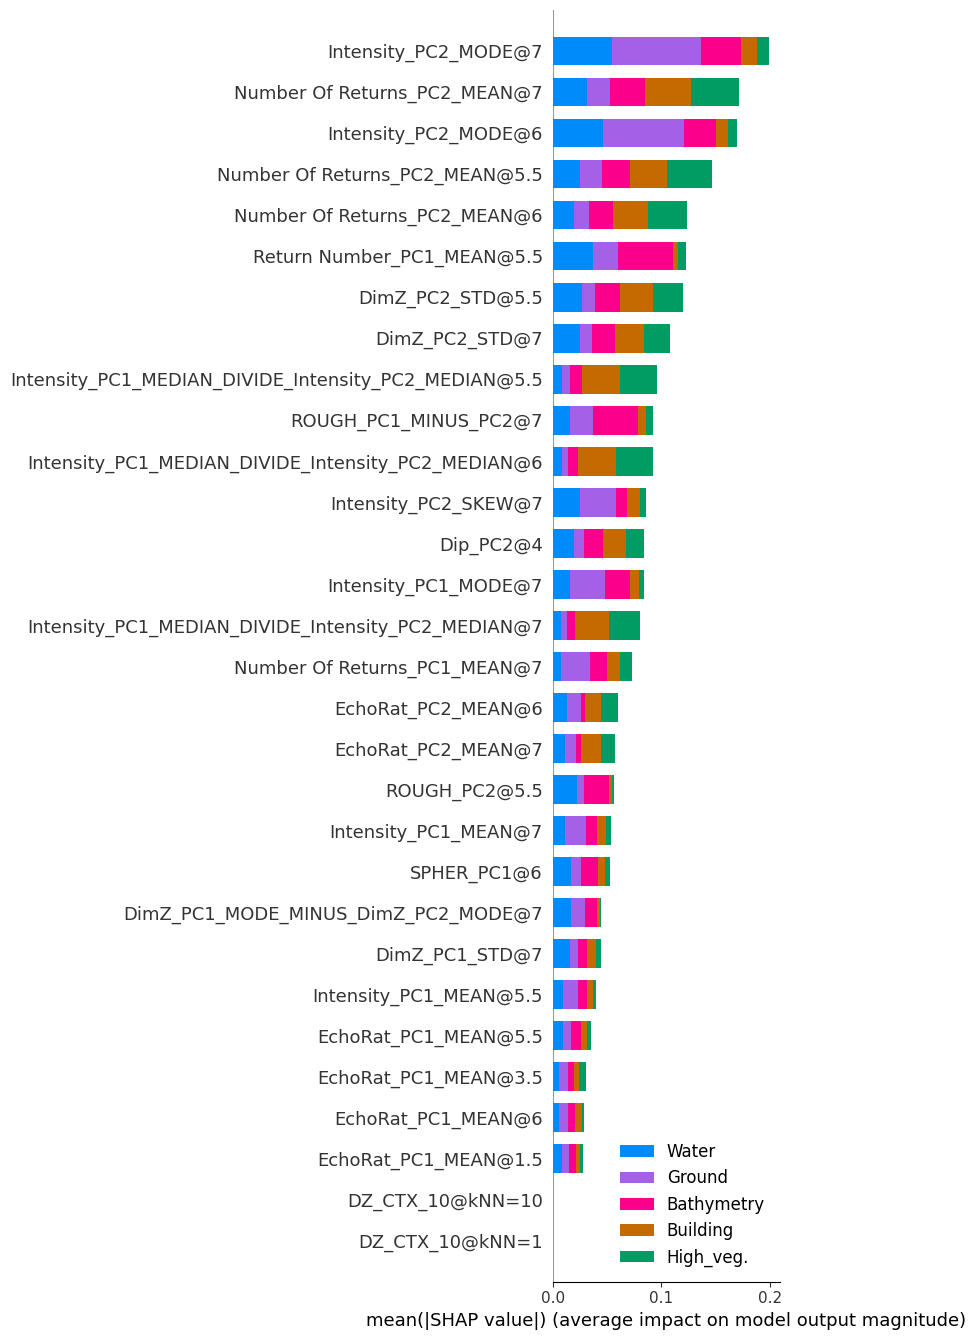

[array([[-0.01209098, -0.00473718, -0.00540928, ...,  0.01009475,
          0.01156978, -0.00730839],
        [ 0.00346422,  0.00308345,  0.00590771, ...,  0.00353601,
          0.0042091 ,  0.01083608],
        [-0.00379104, -0.00201874, -0.00574223, ..., -0.00248898,
         -0.00275626, -0.00459619],
        ...,
        [ 0.00016419, -0.0001878 , -0.00112415, ...,  0.00111922,
          0.00242668, -0.0030623 ],
        [ 0.00141229, -0.00047744, -0.00111478, ...,  0.00093231,
          0.00235878, -0.00319462],
        [ 0.00150016, -0.00013291, -0.00112415, ...,  0.0011385 ,
          0.00245994, -0.00265049]]),
 array([[ 1.65698642e-02,  2.73866256e-03,  2.13694916e-03, ...,
          1.15286400e-01,  8.67680813e-02,  8.89596296e-03],
        [-5.61389954e-05, -2.02685460e-04, -2.37083134e-03, ...,
         -3.24503671e-04,  2.10235649e-03, -5.15220492e-03],
        [ 3.89425217e-03,  5.43625978e-03,  1.43623253e-02, ...,
          6.63877310e-02,  6.55961155e-02,  5.60178912e-

In [14]:
cc_3dmasc.get_shap_expl(classifier, val_ds, save=False)

*The printed values are the SHAP values.*